In [1]:
import essentia
import math
from essentia import *

import essentia.standard as std
import IPython.display as ipd
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt

import librosa
import scipy
from scipy import spatial, signal 

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [122]:
def buscar_frecuencia(texto):
    frecuencias = [20, 30, 40, 60, 80, 120, 160, 240, 320, 480, 640, 960, 1280, 1920, 2560, 3840, 5120, 7680, 10240, 15360, 20480]
    voltajes = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
    for i, voltaje in enumerate(voltajes):
        if str(voltaje) in texto:
            return frecuencias[i]
    return None


def similitud_coseno_MFCC(original, remake):
    original_mfcc = librosa.feature.mfcc(y=original,sr=sampleRate)
    syntesis_mfcc = librosa.feature.mfcc(y=remake,sr=sampleRate)

    n = syntesis_mfcc.shape[1]
    coss_sim = np.zeros(n)

    for i in range(n):
        original = original_mfcc[1:, i]
        syntesis = syntesis_mfcc[1:, i]
        coss_sim[i] = 1 - spatial.distance.cosine(original, syntesis)


    similitud_value = np.round(np.mean(coss_sim),4)
          
    return similitud_value

def cut_audio_one_period(audio, sampleRate):
    
    freq_fund_teorica = buscar_frecuencia(file_name)
    
    # Realizar la transformada de Fourier
    fft = np.fft.fft(audio)

    # Obtener la amplitud de la transformada
    magnitude = np.abs(fft)

    # Obtener las frecuencias correspondientes
    frequencies = np.fft.fftfreq(len(audio), 1/sampleRate)

    # Encontrar la frecuencia fundamental
    print(np.max(magnitude))
    for i in range(len(magnitude)):
        if magnitude[i]>80:
            freq_fund_calculada = np.abs(frequencies[i])
            break
    print('Frequencia fund. del señal calculada: ' + str(freq_fund_calculada))
    print('Frequencia fund. del señal según la tabla: ' + str(freq_fund_teorica))
    
    #Esta forma no siempre funciona ya que la frec. fundamental puede tenr un harmonico de mayor magnitud que ella misma
    # fundamental_freq = np.abs(frequencies[np.argmax(magnitude)])

    # calcular la duración de un periodo en SEGUNDOS i SAMPLES
    period = np.abs(1/freq_fund_teorica)
    period_samples = int(period*sampleRate)
    print('Period Samples: ' + str(period_samples))

    # Calcular el número de períodos actuales en el audio
    num_periods = int(len(audio) / period_samples)
    
    #obtener versión del audio de solo 1 periodo
    audio_cut = audio[15:period_samples+15] # no se coge del principip porque algunos audios presentan clicks al inicio
    
    return audio_cut, num_periods, period



def remake_audio_frome_period(audio_cut, num_periods):

    # Alargar el audio utilizando la función numpy.tile
    audio_remake = np.tile(audio_cut, int(num_periods))
    
    return audio_remake, audio



1171.5152964097083
Frequencia fund. del señal calculada: 10019.668676887306
Frequencia fund. del señal según la tabla: 10240
Period Samples: 2


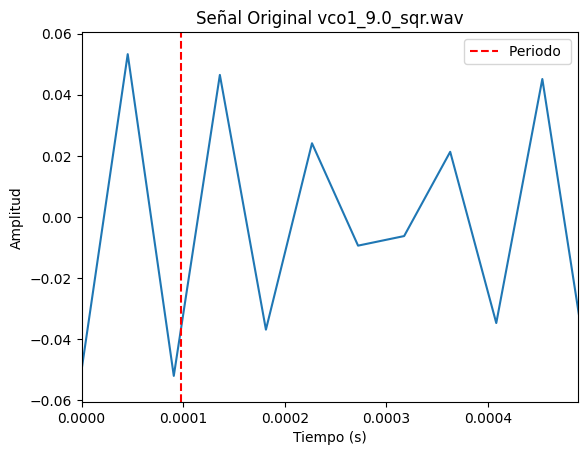

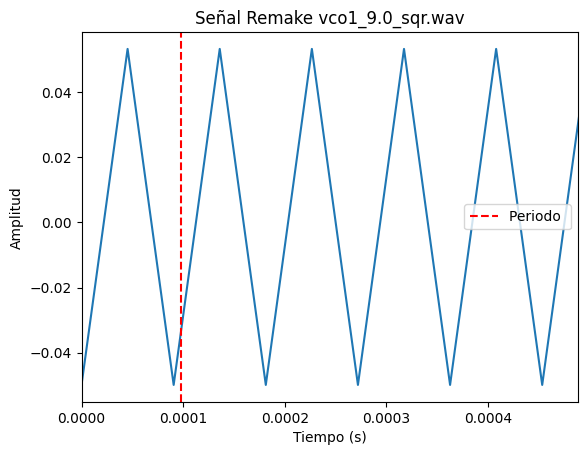

Similitud coseno entre MFCC, media = 0.6578


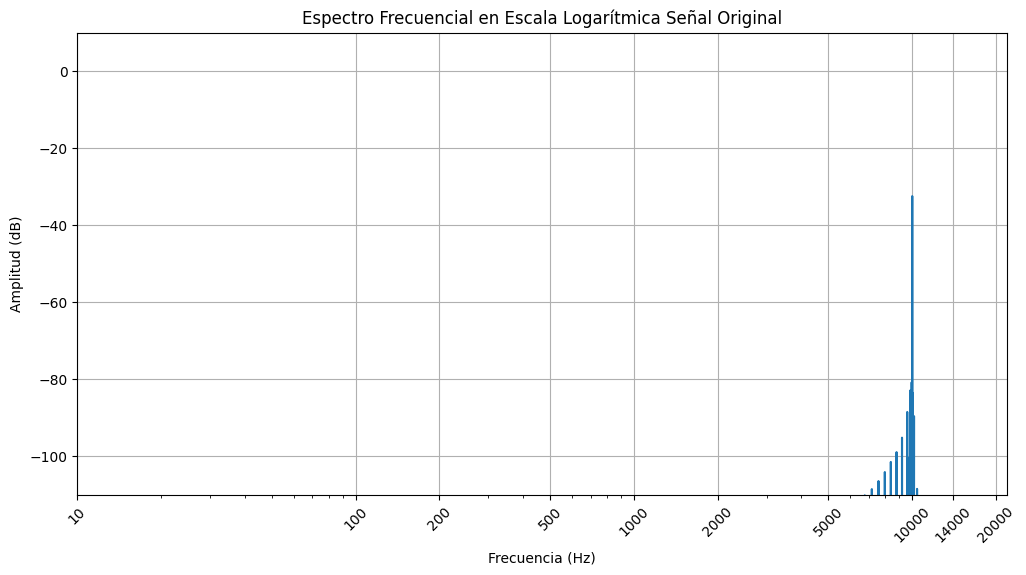

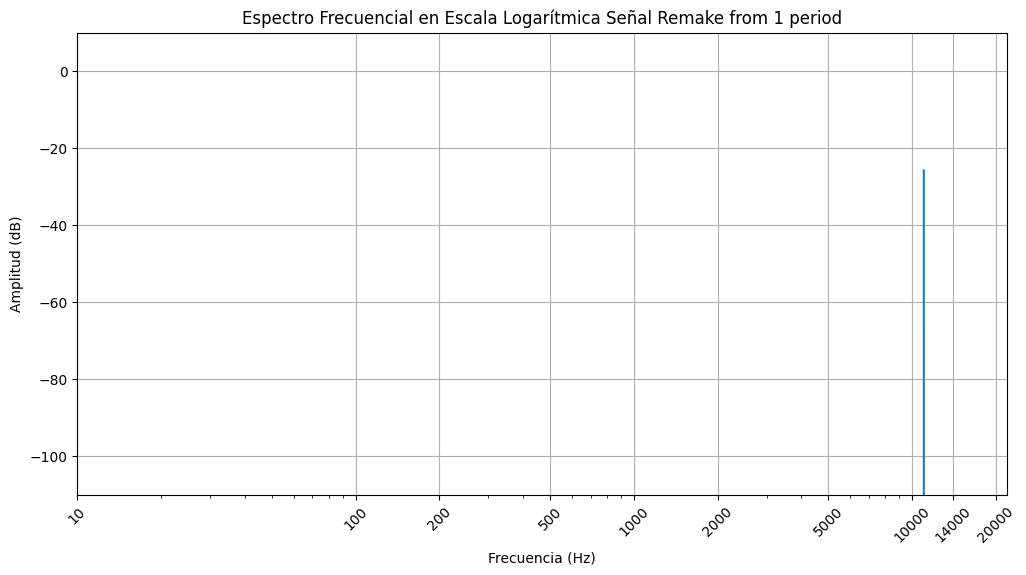

In [123]:
input_file = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square/vco1_9.0_sqr.wav'
# input_file = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square/vco1_5.0_sqr.wav'

file_name = input_file.split("/")[-1]


audio, sampleRate = librosa.load(input_file)

audio_cut, num_periods, period = cut_audio_one_period(audio, sampleRate)
audio_remake, audio = remake_audio_frome_period(audio_cut, num_periods)

audio = audio[15:]
# Calcular la duración total de la señal
total_time = len(audio_remake) / sampleRate

# Definir los límites del eje x como un rango que cubra 4 veces el período
x_lim = [0, 5 * period]
# Realizar el plot de la señal original
plt.plot(np.arange(len(audio)) / sampleRate, audio)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Original ' + file_name)
plt.axvline(x=period, color='r', linestyle='--', label='Periodo ')
# period_theoric = 1/freq_fund_teorica
# plt.axvline(x=period_theoric, color='g', linestyle='--', label='Periodo teórico')

plt.legend()
plt.xlim(x_lim)
plt.show()
# Realizar el plot de la señal remake
plt.plot(np.arange(len(audio_remake)) / sampleRate, audio_remake)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Remake ' + file_name)
plt.axvline(x=period, color='r', linestyle='--', label='Periodo ')
# period_theoric = 1/freq_fund_teorica
# plt.axvline(x=period_theoric, color='g', linestyle='--', label='Periodo teórico')

plt.legend()
plt.xlim(x_lim)
plt.show()


# Ejemplo de como visualizar  el espectro y marcar la freq. fundamental

# Plot del espectro de frecuencias
# plt.plot(frequencies[:len(frequencies)//2], 20 * np.log10(magnitude[:len(magnitude)//2]))
# plt.xlabel("Frecuencia (Hz)")
# plt.ylabel("Amplitud (dB)")
# plt.xlim([0, sampleRate/2])
# plt.ylim([-60, 30])

# plt.axvline(x=freq_fund_calculada, color='r', linestyle='--', label='Frecuencia fundamental: ' + str(freq_fund_calculada))
# plt.legend()
# plt.show()



ipd.display(ipd.Audio(data=audio, rate=sampleRate))
ipd.display(ipd.Audio(data=audio_remake, rate=sampleRate))

similitud_value = similitud_coseno_MFCC(audio, audio_remake)
print("Similitud coseno entre MFCC, media = "+str(similitud_value))

def plot_espectro_log(audio, sr, signal_tag):

    fig = plt.figure(figsize=(12, 6)) # create a figure with custom size
    
    plt.magnitude_spectrum(audio, Fs=sr, scale='dB')
    plt.title('Espectro Frecuencial en Escala Logarítmica Señal ' + signal_tag)
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Amplitud (dB)')
    plt.grid()
    plt.xlim([10, 22000]) # set the limits of the x axis
    plt.ylim([-110, 10]) # set the limits of the y axis
    plt.xscale('log')
    plt.xticks([10, 100, 200, 500, 1000, 2000, 5000, 10000, 14000, 20000], 
               ["10", "100", "200", "500", "1000", "2000", "5000", "10000", "14000", "20000"], 
               rotation=45) # set the location of the tick marks on the x axis
    
    plt.show()

plot_espectro_log(audio, sampleRate, 'Original')
plot_espectro_log(audio_remake, sampleRate, 'Remake from 1 period')
